In [28]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 9

IMG_SIZE = 32
N_CLASSES = 10

In [30]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [31]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [32]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            logits = model(X)
            probs = F.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probs, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [33]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [34]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [35]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [88]:
class SquareLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x_sq = torch.square(x)
        return x_sq

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        # Start with average pooling
        # self.feature_extractor = nn.Sequential(      
        #     nn.AvgPool2d(kernel_size=2),      
        #     nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1),
        #     nn.Tanh(),
        #     nn.AvgPool2d(kernel_size=2),
        #     nn.Conv2d(in_channels=6, out_channels=16, kernel_size=2, stride=1),
        #     nn.Tanh(),
        #     nn.AvgPool2d(kernel_size=2),
        #     nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1),
        #     nn.Tanh()
        # )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

class LeNet5small(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5small, self).__init__()

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5, stride=2),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

class MyModel(nn.Module):
    def __init__(self, n_classes) -> None:
        super(MyModel, self).__init__()

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=3920, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits
    


In [89]:
torch.manual_seed(RANDOM_SEED)

model = MyModel(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

16:06:54 --- Epoch: 0	Train loss: 0.1613	Valid loss: 0.0639	Train accuracy: 98.53	Valid accuracy: 97.98
16:08:29 --- Epoch: 1	Train loss: 0.0549	Valid loss: 0.0546	Train accuracy: 99.02	Valid accuracy: 98.13
16:10:09 --- Epoch: 2	Train loss: 0.0350	Valid loss: 0.0466	Train accuracy: 99.47	Valid accuracy: 98.48
16:11:48 --- Epoch: 3	Train loss: 0.0238	Valid loss: 0.0529	Train accuracy: 99.64	Valid accuracy: 98.56
16:13:43 --- Epoch: 4	Train loss: 0.0161	Valid loss: 0.0539	Train accuracy: 99.72	Valid accuracy: 98.60
16:15:32 --- Epoch: 5	Train loss: 0.0124	Valid loss: 0.0566	Train accuracy: 99.66	Valid accuracy: 98.65
16:17:16 --- Epoch: 6	Train loss: 0.0114	Valid loss: 0.0735	Train accuracy: 99.76	Valid accuracy: 98.31
16:19:08 --- Epoch: 7	Train loss: 0.0093	Valid loss: 0.0585	Train accuracy: 99.83	Valid accuracy: 98.53
16:20:50 --- Epoch: 8	Train loss: 0.0072	Valid loss: 0.0791	Train accuracy: 99.66	Valid accuracy: 98.18


C:\Users\mrnocker\AppData\Local\Temp\ipykernel_15664\1591329956.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


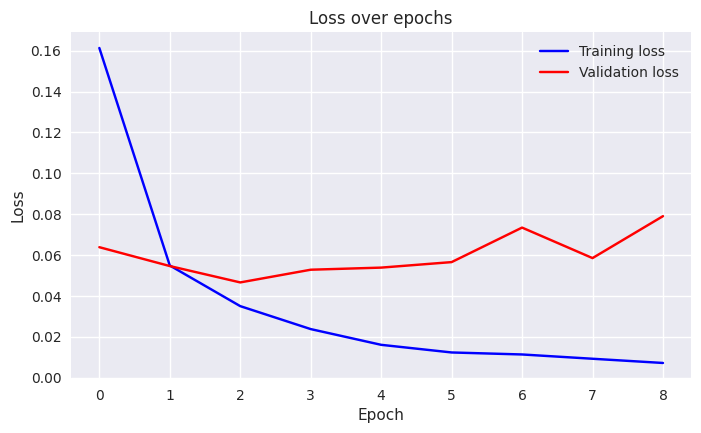

In [90]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        logits = model(valid_dataset[index][0].unsqueeze(0))
        probs = F.softmax(logits, dim=1)
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [27]:
print(np.expand_dims(valid_dataset[0][0].detach().numpy(), 0).shape)

for i in range(1000):
    np.save("mnist_32x32_tenseal/{}.npy".format(i), np.expand_dims(valid_dataset[i][0].detach().numpy(), 0))


(1, 1, 32, 32)


In [ ]:
!rm -r mnist_data

In [91]:
import torch.onnx

dummpy_input = torch.randn(1, 1, 32, 32)

torch.onnx.export(model, dummpy_input, "lenet-5.onnx", export_params=True, opset_version=14, do_constant_folding=True,
    input_names=["input"], output_names=["output"])

In [17]:
wrong_instances = []
hard_instances = []

for i in range(len(valid_dataset.data)):
    image, label = valid_dataset[i]
    with torch.no_grad():
        model.eval()
        logits = model(image.unsqueeze(0))
        probs = F.softmax(logits, dim=1)
    
    if torch.argmax(probs) != label:
        wrong_instances.append(i)
    elif torch.max(probs) < 0.7:
        hard_instances.append(i)

print(wrong_instances)
print(hard_instances)

[247, 259, 340, 359, 445, 495, 582, 625, 659, 674, 720, 846, 947, 965, 1014, 1182, 1226, 1232, 1247, 1319, 1393, 1444, 1522, 1530, 1678, 1737, 1878, 1901, 1982, 2035, 2098, 2129, 2130, 2135, 2182, 2189, 2369, 2406, 2462, 2488, 2597, 2648, 2654, 2720, 2896, 2921, 2927, 2990, 3073, 3225, 3422, 3520, 3550, 3558, 3626, 3727, 3767, 3808, 3853, 3869, 3906, 3941, 3968, 3985, 4176, 4256, 4360, 4497, 4536, 4571, 4671, 4699, 4731, 4761, 4823, 4956, 5937, 5955, 5972, 5981, 5982, 5997, 6028, 6569, 6576, 6597, 6598, 6651, 6783, 7928, 9634, 9729, 9770]
[448, 716, 844, 1039, 1260, 1900, 2109, 2291, 2414, 2953, 4224, 4507, 4807, 6053, 6571, 6572, 6625, 6883, 8094, 8105, 9280, 9692, 9792]


In [ ]:
for hard in hard_instances:
    image, label = valid_dataset[hard]
    plt.figure(figsize=(2,2))
    plt.axis("off")
    plt.title("{}".format(label))
    plt.imshow(image.squeeze())
    plt.show()